# Subgraph/clustering analysis of Nanog overexpression tf/ppi graph

## Analysis:

1. Hierarchical clustering
2. Identify clusters with NANOG
3. Identify breakpoint to separate NANOG cluster
    - Figure out ratio of inside edges to outside edges of each cluster
    - Figure out size of each cluster (edges, vertices)
4. Separate NANOG cluster at appropriate level
5. Re-cluster with ordering
6. Identify top/bottom of hierarchy
7. Figure out biology of ranking
    - Go analysis at each level of hierarchy

In [49]:
import pickle

In [50]:
import networkx as nx

In [51]:
from graph_tool.all import *

In [52]:
import numpy as np

In [53]:
import graph_tool as gt

In [54]:
from nx2gt import nx2gt

In [55]:
graph = pickle.load(open('filtered_graph.pickle','rb'))

In [56]:
# Convert to graphtool graph from networkx
graph =nx2gt(graph)

In [57]:
graph.num_edges()

275

In [58]:
graph.num_vertices()

128

### Hierarchical Clustering

In [59]:
def refine(state, n=1000):
    s1 = state.entropy()
    for i in range(n): # this should be sufficiently large
        state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

    s2 = state.entropy()
    return state, s1, s2

In [60]:
hierarchical = gt.inference.minimize_nested_blockmodel_dl(graph)

In [61]:
r_state_dc, s1, s2 = refine(hierarchical)
print(s1, s2, s1-s2)

1354.7664898164683 1340.616211098725 14.150278717743277


In [62]:
r_state_dc, s1, s2 = refine(hierarchical, 10)
print(s1, s2, s1-s2)

1340.616211098725 1340.616211098725 0.0


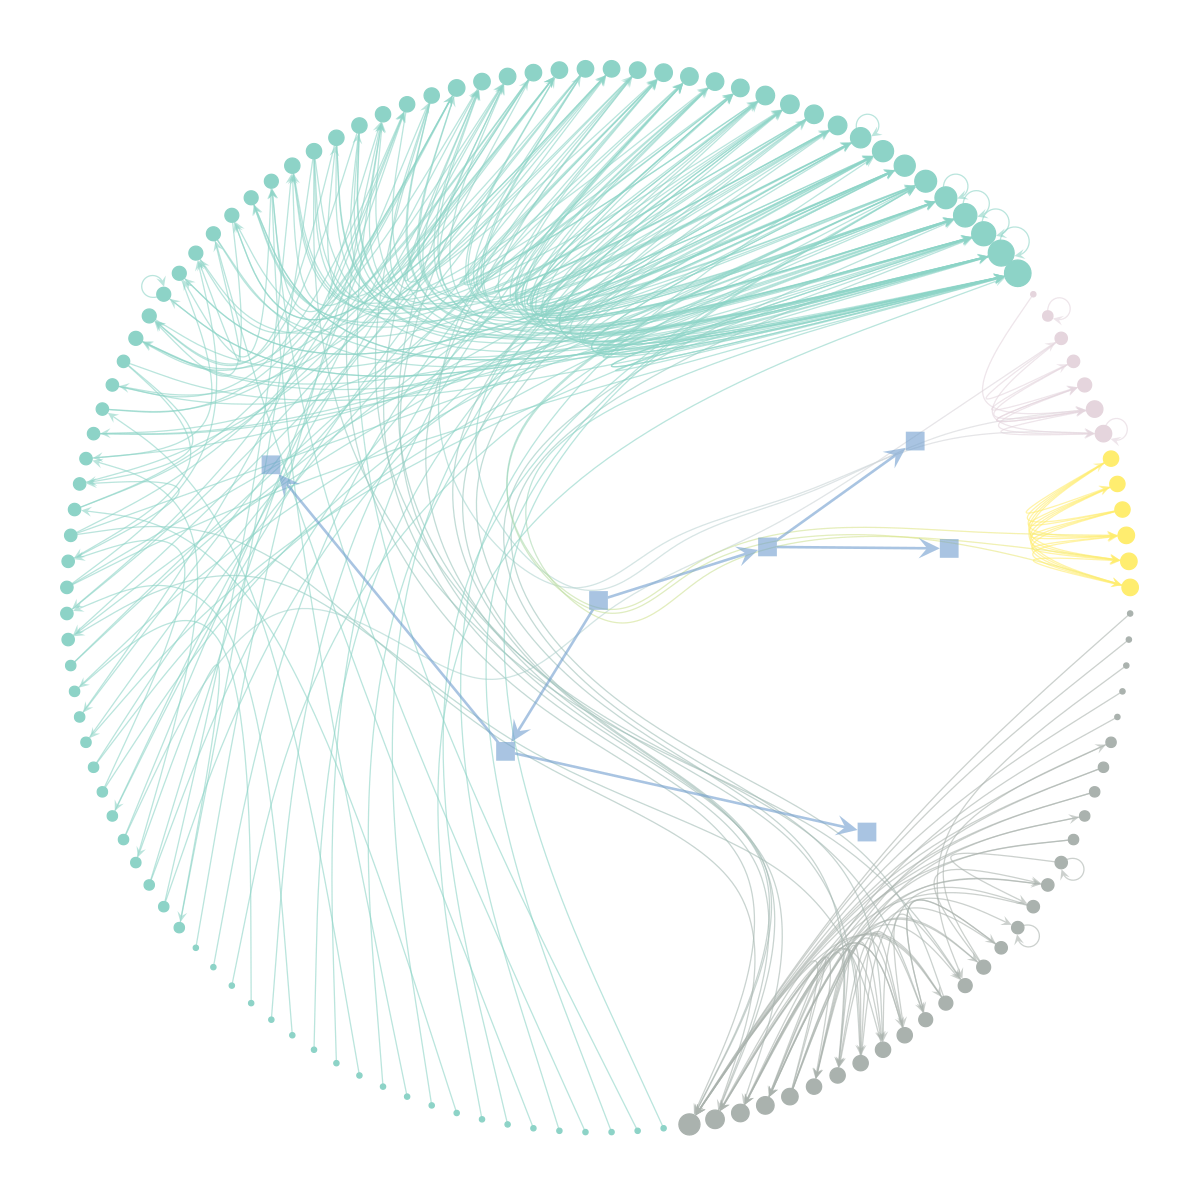

In [63]:
hierarchical.draw();

In [64]:
levels = [level for level in hierarchical.levels if level.get_nonempty_B() > 1]
for level in levels:
    print(level)

<BlockState object with 129 blocks (4 nonempty), degree-corrected, for graph <Graph object, directed, with 128 vertices and 275 edges, 1 internal vertex property, 4 internal edge properties, at 0x7f7abadc3d90>, at 0x7f7b4ab61480>
<BlockState object with 5 blocks (2 nonempty), for graph <Graph object, directed, with 129 vertices and 8 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f7abadc28f0>, at 0x7f7b4aba7130>


In [65]:
n_vertices = hierarchical.g.num_vertices()
n_levels = len(levels)
vertex_blocks = np.zeros((n_vertices, n_levels), dtype=int)

blocks = hierarchical.levels[0].get_blocks()

for i,block in enumerate(blocks):
    vertex_blocks[i, 0] = block

for i in range(1, n_levels):
    current_blocks = hierarchical.levels[i].get_blocks()
#     print(len(list(current_blocks)))
    for j,last_block in enumerate(vertex_blocks[:,i-1]):
        block = current_blocks[last_block]
        vertex_blocks[j,i] = block

In [66]:
for i in range(10):
    for j in range(len(levels)):
        print(f'{vertex_blocks[i,j]:4d}',end=',')
    print()

 116,   0,
  55,   0,
 116,   0,
 116,   0,
 116,   0,
 116,   0,
 116,   0,
 116,   0,
  55,   0,
 116,   0,


## Identify clusters with NANOG

In [67]:
protein_id_to_name = pickle.load(open('../data/protein_id_to_name.pickle','rb'))
gene_id_to_name = pickle.load(open('../data/gene_id_to_name.pickle','rb'))

names_to_protein_ids = pickle.load(open('../data/protein_names.pickle','rb'))
names_to_gene_ids = pickle.load(open('../data/gene_names.pickle','rb'))

In [68]:
nanog_ids = names_to_gene_ids['NANOG'] | names_to_protein_ids['NANOG']
nanog_ids

{'ENSMUSG00000012396',
 'ENSMUSP00000012540',
 'ENSMUSP00000108199',
 'ENSMUSP00000108200'}

In [69]:
# from ast import literal_eval as make_tuple

In [70]:
nanog_vertices = []
for i,vertex in enumerate(graph.vertices()):
#     print(i, vertex)
    for nanog_id in nanog_ids:
        vertex_name = graph.vertex_properties['id'][vertex]
        if vertex_name == nanog_id:
#             assert i==vertex, f'{i}, {vertex}'
            print(i,vertex, vertex_name, vertex_blocks[i])
            nanog_vertices.append(i)

29 29 ENSMUSP00000012540 [116   0]


## Separate out NANOG cluster into subgraph

In [71]:
nanog_block = vertex_blocks[nanog_vertices[0]][-1]

In [72]:
nanog_block

0

In [73]:
nanog_filter = vertex_blocks[:,-1] == nanog_block

In [74]:
nanog_filter.shape

(128,)

In [75]:
len(list(graph.vertices()))

128

In [76]:
graph.set_vertex_filter(graph.new_vertex_property('bool',vals=nanog_filter))

In [77]:
ngraph = Graph(graph, prune=True)

In [78]:
ngraph

<Graph object, directed, with 115 vertices and 243 edges, 1 internal vertex property, 4 internal edge properties, at 0x7f7abafa8c70>

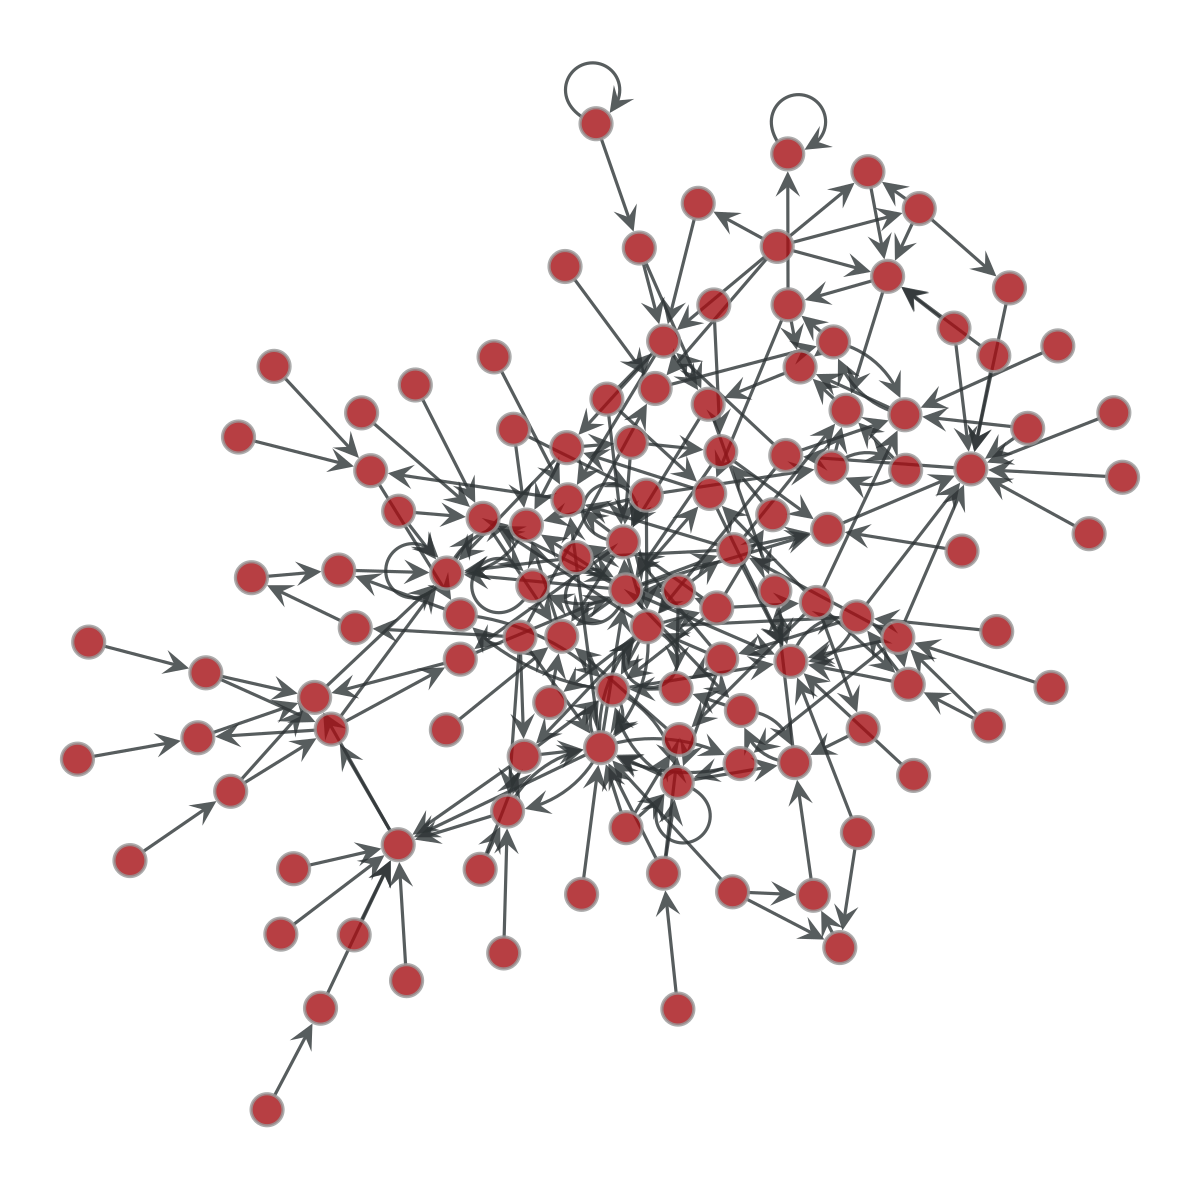

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7abafa8c70, at 0x7f7abad68cd0>

In [79]:
graph_draw(ngraph)

## Recluster with ordering

In [80]:
ranked = RankedBlockState(ngraph)
for i in range(100):
    ranked.multiflip_mcmc_sweep(beta=np.inf, niter=10)

In [81]:
ranked

<RankedBlockState object with 2 blocks, 8 upstream, 6 downstream, and 229 lateral edges, degree-corrected, for graph <Graph object, directed, with 115 vertices and 243 edges, 1 internal vertex property, 4 internal edge properties, at 0x7f7abafa8c70>, at 0x7f7abad68760>

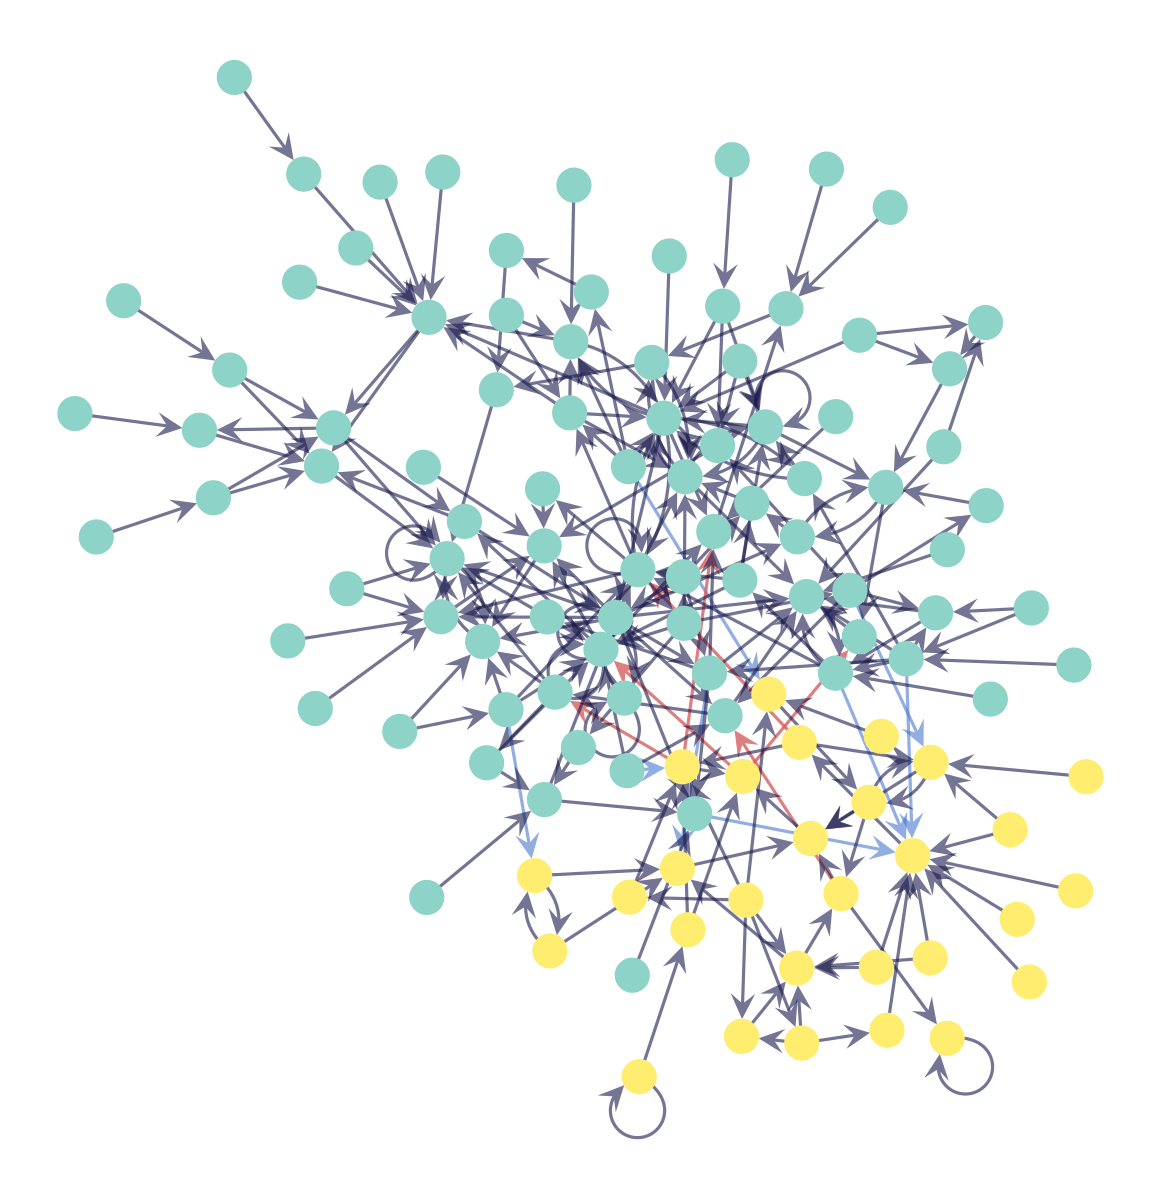

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7abafa8c70, at 0x7f7abafa9e70>

In [82]:
ranked.draw()

## Calculate enrichment of genes in each cluster in the network

In [84]:
from pprint import pprint
import json
import requests

In [104]:
go_names = pickle.load(open('../data/go_bio_process_2021_names.pickle','rb'))

In [105]:
len(go_names)

14937

In [115]:
names = []
for i in range(ranked.get_B()):
    names.append([])
    block = np.argwhere(ranked.get_vertex_order().a == i)
    for node_id in block:
        ensembl_id = graph.vertex_properties['id'][node_id[0]]
#         print(node_id[0], ensembl_id, protein_id_to_name[ensembl_id])
        names[i]+=[name for name in protein_id_to_name[ensembl_id] if name in go_names]
#     print('-------')

In [116]:
names

[['SUFU',
  'RND3',
  'BACE1',
  'MYC',
  'FOSL1',
  'TRAM1',
  'RAC3',
  'NCOA3',
  'ZFPM1',
  'BCL11B',
  'RIT1',
  'SERPINH1',
  'DKK1',
  'KDM6B',
  'GLI1',
  'LMO2',
  'ESR1',
  'FOXC2',
  'MMP2',
  'NFKB1',
  'DLX5',
  'ID3',
  'DNMT3A',
  'ESRRB',
  'GLI3',
  'TFAP2C',
  'MMP15',
  'NANOG',
  'HOXB4',
  'RUNX1',
  'GFI1B',
  'NDN',
  'HOXB5',
  'SNAI2',
  'ETS1',
  'SATB1',
  'DACH1',
  'SHH',
  'MIXL1',
  'PBX1',
  'MEF2C',
  'ELF4',
  'TBX3',
  'HOXB6',
  'PAX2',
  'LMX1B',
  'TCF4',
  'HNF4A',
  'SOX9',
  'HOXA2',
  'TIMP3',
  'CDX2',
  'FOXF1',
  'MSX1',
  'EYA2',
  'SNAI1',
  'FOXM1',
  'HNF1B',
  'DNMT3B',
  'WT1',
  'MMP9',
  'GSC',
  'ING4',
  'ISL1',
  'NOTCH1',
  'ZSCAN10',
  'PRRX1',
  'IKZF1',
  'SMAD6',
  'NFKBIZ',
  'TBX20',
  'TWIST1',
  'CHD7',
  'TAL1',
  'FOXC1',
  'RARB',
  'POU5F1',
  'TBX1',
  'WLS',
  'LHX5',
  'LIM2',
  'RPSA',
  'RPS3A',
  'POLR2L',
  'MED12',
  'HIP1',
  'HHIP',
  'ROR2',
  'MAP2K6'],
 ['FOXD3',
  'PITX1',
  'TFCP2L1',
  'MAFB',
  'FOXQ1

In [85]:
def query_enrichr(names, gene_set_library):
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(names)
    description = 'Example gene list'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    data = json.loads(response.text)
#     print(data)

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    user_list_id = data['userListId']
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')
    return json.loads(response.content)

In [86]:
def print_enrichment(response, gene_set_library):
    for i,enr in enumerate(response[gene_set_library]):
        for j in [1, 6]:
            print(headers[j], enr[j])
        print(', '.join(enr[5]))
        print('-')

In [87]:
gene_set_library = 'GO_Biological_Process_2021'

In [ ]:
headers = ['Rank', 'Term name', 'P-value', 'Z-score', 'Combined score', 'Overlapping genes', 
           'Adjusted p-value', 'Old p-value', 'Old adjusted p-value']

In [117]:
response = query_enrichr(names[0], gene_set_library)
print_enrichment(response, gene_set_library)

Term name regulation of transcription by RNA polymerase II (GO:0006357)
Adjusted p-value 6.900393446342111e-40
IKZF1, GLI1, FOXM1, ETS1, GLI3, MED12, SHH, DACH1, MYC, HNF4A, SUFU, DNMT3B, HOXA2, SOX9, KDM6B, MEF2C, NCOA3, LMO2, DNMT3A, HNF1B, DKK1, ISL1, PAX2, POU5F1, RUNX1, ELF4, TAL1, HOXB4, RARB, LMX1B, ZFPM1, HOXB6, HOXB5, FOXC2, FOXC1, NOTCH1, DLX5, SATB1, TWIST1, GSC, ZSCAN10, TBX20, MSX1, TBX1, TFAP2C, CDX2, PRRX1, BCL11B, FOXF1, ESRRB, SMAD6, ESR1, NFKB1, PBX1, TBX3, FOSL1, GFI1B, WT1, SNAI1, ID3, SNAI2, NANOG, TCF4, LHX5, MIXL1
-
Term name regulation of transcription, DNA-templated (GO:0006355)
Adjusted p-value 2.53305811176979e-33
CHD7, IKZF1, GLI1, FOXM1, ETS1, GLI3, MED12, ING4, SHH, DACH1, MYC, HNF4A, SUFU, HOXA2, SOX9, MEF2C, HNF1B, ISL1, PAX2, POU5F1, RUNX1, ELF4, TAL1, HOXB4, LMX1B, HOXB6, HOXB5, FOXC2, FOXC1, NOTCH1, DLX5, SATB1, TWIST1, GSC, ZSCAN10, TBX20, MSX1, POLR2L, TBX1, TFAP2C, CDX2, PRRX1, BCL11B, FOXF1, ESRRB, SMAD6, ESR1, NFKB1, PBX1, TBX3, FOSL1, GFI1B, WT1

In [118]:
response = query_enrichr(names[1], gene_set_library)
print_enrichment(response, gene_set_library)

Term name regulation of transcription by RNA polymerase II (GO:0006357)
Adjusted p-value 3.2579945323449176e-16
FOXD3, SMAD3, MSX2, CDX1, CITED2, HMGA2, SIX1, FOS, TFCP2L1, FOXO4, GATA1, FLI1, FOSL2, GLI2, FOXQ1, HOXA10, ZFP36, MAFB, MAF, GBX2, SIX3, PITX2, PITX1, FOXA2
-
Term name regulation of transcription, DNA-templated (GO:0006355)
Adjusted p-value 7.834427259288655e-15
FOXD3, SMAD3, MSX2, CDX1, CITED2, HMGA2, SIX1, FOS, TFCP2L1, FOXO4, GATA1, FLI1, FOSL2, GLI2, FOXQ1, HOXA10, MAFB, MAF, GBX2, SIX3, PITX2, PITX1, FOXA2
-
Term name positive regulation of transcription, DNA-templated (GO:0045893)
Adjusted p-value 1.1246259709170593e-10
FOXD3, SMAD3, CDX1, CITED2, HMGA2, SIX1, FOS, FOXO4, GATA1, FLI1, FOSL2, GLI2, HOXA10, MAFB, PITX2, FOXA2
-
Term name positive regulation of transcription by RNA polymerase II (GO:0045944)
Adjusted p-value 7.461043739788936e-10
FOXD3, SMAD3, CDX1, CITED2, HMGA2, SIX1, FOS, FOXO4, GATA1, FOSL2, GLI2, HOXA10, PITX2, FOXA2
-
Term name positive regulation

## Processes controlled by network, i.e. output nodes

In [119]:
output_nodes = pickle.load(open('output_nodes.pickle','rb'))

In [120]:
output_names = []
for protein_id in output_nodes:
    output_names += [name for name in protein_id_to_name[protein_id] if name in go_names]


In [121]:
print(len(output_names))

287


In [122]:
response = query_enrichr(output_names, gene_set_library)
print_enrichment(response, gene_set_library)

Term name transmembrane receptor protein tyrosine kinase signaling pathway (GO:0007169)
Adjusted p-value 4.822711610302294e-15
RET, KLB, NRP1, IRS1, FLT4, ITGB3, FGF3, SOCS2, EFNB1, FGF8, ERBB2, GRB10, PDGFRB, NGFR, PDGFRA, ANGPT1, BDNF, IGF2, IGF1, MAPK14, GFRA2, PGF, VEGFA, COL1A1, COL4A2, MAPKAPK3, KIT, DDIT4, ELMO1, GRB2, TEK, PRKD1, EPHA1, FGFR2, EPHA2, FGFR1
-
Term name extracellular matrix organization (GO:0030198)
Adjusted p-value 8.560086413038456e-14
FBN2, ITGB4, LAMA1, ITGB3, LAMA4, ITGA2B, PLG, NID1, SCUBE3, TTR, CAPN2, A2M, FGB, VCAM1, ITGA4, ITGA3, FGG, FN1, BGN, HSPG2, COL1A1, COL2A1, COL4A2, COL5A1, COL6A2, NF1, ITGA7, ADAM8, CD44, ITGA9
-
Term name extracellular structure organization (GO:0043062)
Adjusted p-value 6.792520688594074e-13
FBN2, ITGB4, LAMA1, ITGB3, LAMA4, ITGA2B, NID1, TTR, FGB, VCAM1, ITGA4, ITGA3, FGG, FN1, BGN, HSPG2, COL1A1, COL2A1, COL4A2, COL5A1, COL6A2, NF1, ITGA7, CD44, ITGA9
-
Term name external encapsulating structure organization (GO:0045229)
A